In [4]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
def load_images_from_folders(main_folder):
    images = []
    labels = []
    
    # Traverse each subdirectory (which corresponds to a class)
    for class_label in os.listdir(main_folder):
        class_folder = os.path.join(main_folder, class_label)
        
        if os.path.isdir(class_folder):
            for image_file in os.listdir(class_folder):
                # Load the image
                image_path = os.path.join(class_folder, image_file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                
                if image is not None:
                    images.append(image)
                    labels.append(class_label)  # Assign class label
    
    return images, labels

In [6]:
sift = cv2.SIFT_create()
# Step 2: Extract SIFT Features
def extract_sift_features(image):
    # Initialize SIFT detector
   
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    return descriptors

In [7]:
def extract_descriptors_for_images(images):
    descriptors_list = []
    
    for image in images:
        descriptors = extract_sift_features(image)
        if descriptors is not None:
            descriptors_list.append(descriptors)
    
    return descriptors_list

In [8]:
# Step 3: Build Bag of Visual Words (BoVW)
def build_bow(descriptors_list, num_clusters=100):
    # Stack all descriptors vertically
    descriptors_stack = np.vstack(descriptors_list)
    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(descriptors_stack)
    
    return kmeans

In [9]:
def generate_feature_vector(descriptors, kmeans):
    # Assign each descriptor to a cluster center
    labels = kmeans.predict(descriptors)
    
    # Build histogram of visual word occurrences
    hist, _ = np.histogram(labels, bins=np.arange(kmeans.n_clusters + 1))
    
    return hist

In [10]:

# Path to the main folder containing subfolders for each class
main_folder = 'Data_histEq'
    
# Load images and labels
images, labels = load_images_from_folders(main_folder)

In [11]:
print(len(images))

2152


In [12]:
# Extract SIFT descriptors for each image
descriptors_list = extract_descriptors_for_images(images)
    

In [13]:
# Build the Bag of Visual Words (BoVW) model
num_clusters = 100  # You can adjust this value
kmeans = build_bow(descriptors_list, num_clusters)
    

Accuracy: 58.96%

Confusion Matrix:
[[  1   8   0  17   0   0]
 [  1 102   0  22   0   0]
 [  0  35   1  12   0   0]
 [  0  39   0  60   0   0]
 [  0   1   0   6  86   0]
 [  0  17   0  16   0   0]]


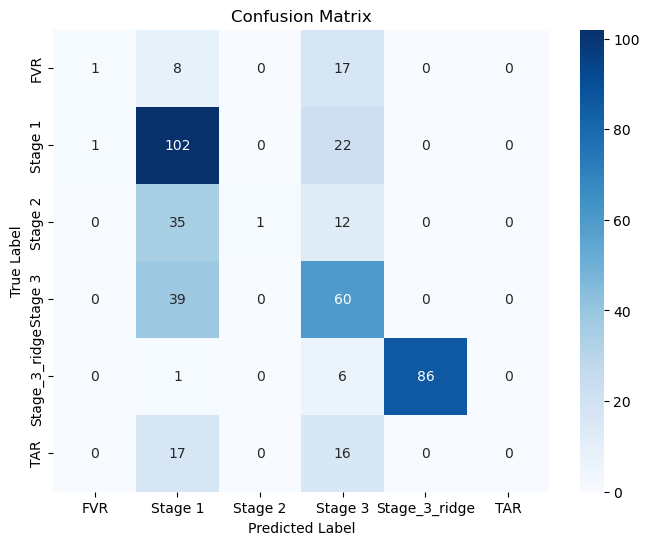


Classification Report:
               precision    recall  f1-score   support

          FVR       0.50      0.04      0.07        26
      Stage 1       0.50      0.82      0.62       125
      Stage 2       1.00      0.02      0.04        48
      Stage 3       0.45      0.61      0.52        99
Stage_3_ridge       1.00      0.92      0.96        93
          TAR       0.00      0.00      0.00        33

     accuracy                           0.59       424
    macro avg       0.58      0.40      0.37       424
 weighted avg       0.62      0.59      0.52       424



/Users/srujanmuralidhar/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/srujanmuralidhar/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/srujanmuralidhar/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Generate feature vectors for all images
X = []
filtered_labels = []

for descriptors, label in zip(descriptors_list, labels):
    if descriptors is not None:
        # Generate feature vector only if descriptors exist
        feature_vector = generate_feature_vector(descriptors, kmeans)
        X.append(feature_vector)
        filtered_labels.append(label)

# Convert labels into numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_labels)

# Now X and y should have the same length
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix using Seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(class_report)


In [15]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Convert labels into numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_labels)

# Now X and y should have the same length
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert lists to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Train XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_classifier.fit(X_train, y_train)

# Predict and evaluate the classifier
y_pred = xgb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'XGBoost Accuracy: {accuracy * 100:.2f}%')


XGBoost Accuracy: 56.84%


In [18]:
import cv2

# Load an image
image = cv2.imread('Data_histEq/Stage 1/FHPL_83-2022_20220922130851_20221020114517_Image_03_0008_2022-10-20_11-46-22-316_1526.png')
 
# Resize the image using OpenCV's resize function
image = cv2.resize(image, (480, 480))
 
# Initialize the SIFT detector
sift = cv2.SIFT_create()
 
# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(image, None)
 
# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
 
cv2.imwrite('output_image.jpg', image_with_keypoints)

True

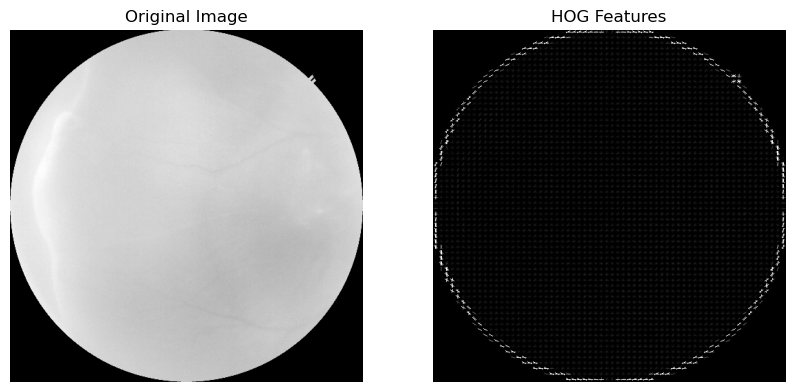

In [17]:
import cv2
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread('Data/Stage 3/FHPL_075-22_20220602114711_20220602114711_Image_07_0035_2022-06-02_11-48-46-592_1526.png', cv2.IMREAD_GRAYSCALE)

# Calculate HOG features
features, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

# Rescale HOG features for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Display the original image and HOG features
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image, cmap=plt.cm.gray)
plt.axis('off')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.title('HOG Features')
plt.axis('off')
plt.show()
